# Graph Partitioning

### Definition

We are given an undirected graph with vertex set $V$ and edge set $E$.

Our aim is to partition the graph into two equally-sized subgraphs connected by the minimal number of edges.


### Applications

The Graph Partitioning problem comes up in computations on graphs. One can parallelise these computations by performing them on subgraphs of the original graph and then concatenate the final solutions with minimal adjustments. The problem also has applications in biological, social and transportation networks, Very Large Scale Integration (VLSI), Image Processing.

### Path to solving the problem

Graph Partitioning is a minimization problem and its cost function can be cast to an Ising problem through its respective Hamiltonian (see the [Introduction](./introduction_combinatorial_optimization.ipynb) and a [reference](https://arxiv.org/abs/1302.5843)),

$$ \displaystyle \large
H = A \displaystyle \left(\textstyle\sum\limits_{i=1}^{N} s_{i} \right) ^2 + B\textstyle\sum\limits_{uv \in E} \frac{1 - s_u s_v}{2}
$$

where $A$ and $B$ are positive constants, $v, u \in V$, $N$ is the number of vertices and $s_i$ is a spin variable, which is $1$ if vertex $i$ is in the one partition and $-1$ if it is in the other. For a valid encoding, the constants $A$ and $B$ need to obey the relation 

$$ 
\frac{A}{B} \geq \frac{\min(2\Delta, N)}{8}
$$ 

where $\Delta$ is the maximum degree of a vertex in the graph. Otherwise, if the rule is not followed, the spin configuration for the lowest energy $H$ may not correspond to the best solution of our Graph Partitioning problem or even to a valid one. At the same time, it should not be overspecified either, i.e. the left side being much bigger than the right side. If the ratio $\frac{A}{B}$ is too large, this would cause a large energy separation in $H$, impeding our solution approach.

The QLM allows us to encode a problem in this Hamiltonian form by using the `GraphPartitioning` class. This class should be provided with a graph, as well as the $A$ and $B$ constants. We can then create a job from the problem and send it to a heuristic Simulated Quantum Annealer (SQA) wrapped inside a Quantum Processing Unit (QPU). The SQA will minimize the Hamiltonian, hence we find the best solution.

For a more detailed explanation and a step-by-step guidance, please follow the sections below.

### Quantum resources

To represent the problem as Ising the QLM would need $N$ spins for each graph vertex. 

# Example problem

Imagine that we are given a graph with $10$ vertices and $18$ edges, as shown below (left). In this case, finding the partitioning may be straightforward. We would only need to remove two edges $-$ one between nodes $1$ and $2$ and another one between nodes $7$ and $8$ (right).

<br><img src="./graph_partitioning_example_solution.png" style="width: 850px"><br>

Let us now describe how one can reach this answer using tools from the QLM. 
Furthermore, the approach will be applicable to finding the Graph Partitioning of any graph !

We will start by specifying the graph using `networkx` and by choosing the constants $A$ and $B$ such that the problem is correctly encoded.

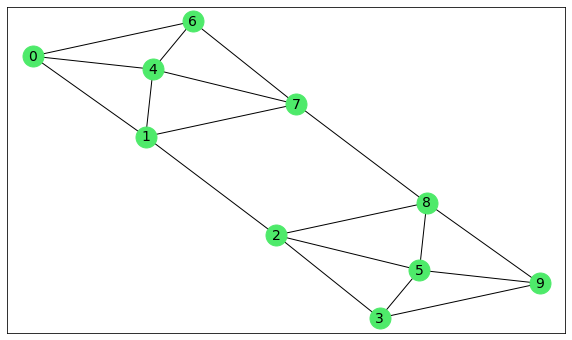

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Specify the graph 
# First example
graph = nx.Graph()
graph.add_nodes_from(np.arange(10))
graph.add_edges_from([(0, 1), (0, 4), (0, 6), (1, 2), (1, 4), 
                      (1, 7), (2, 3), (2, 5), (2, 8), (3, 5), 
                      (3, 9), (4, 6), (4, 7), (5, 8), (5, 9), 
                      (6, 7), (7, 8), (8, 9)])

# # Second example
# graph = nx.gnm_random_graph(30, 80)

# Impose constraints for the right encoding
B = 1
A = 3

# Draw the graph
nodes_positions = nx.spring_layout(graph, iterations=len(graph.nodes()) * 60)
plt.figure(figsize=(10, 6))
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=440, 
                 font_size=14)
plt.show()

The `GraphPartitioning` class can now be called with this graph as an input and with the constants $A$ and $B$.

In [2]:
from qat.opt import GraphPartitioning

graph_partitioning_problem = GraphPartitioning(graph, A, B=B)

# Solution

We can now proceed to compute the solution of the problem by following the steps:

1. Extract the best SQA parameters found for Graph Partitioning by calling the method `get_best_parameters()`.

    The number of Monte Carlo updates is the total number of updates performed for each temperature (and gamma) on the spins of the equivalent 2D classical system. These updates are the product of the number of annealing steps $-$ `n_steps`, the number of "Trotter replicas" $-$ `n_trotters`, and the problem size, i.e. the number of qubits needed. Hence, we can use these parameters to get the best inferred value for `n_steps`. In general, the more these steps are, the finer and better the annealing will be. However this will cause the process to take longer to complete.
    
    Similarly for the `n_trotters` field in `SQAQPU` $-$ the higher it is, the better the final solution could be, but the more time taken by the annealer to reach an answer.


2. Create a temperature and a gamma schedule for the annealing.

    We use the extracted max and min temperatures and gammas to create a (linear) temperature and a (linear) gamma schedule. These schedules evolve in time from higher to lower values since we simulate the reduction of temperatures and magnetic fields. If one wishes to vary them it may help if the min values are close to $0$, as this will cause the Hamiltonian to reach a lower energy state, potentially closer to its ground state (where the solution is encoded).

    It should be noted that non-linear schedules may be investigated too, but for the same number of steps they could lead to a slower annealing. The best min and max values for gamma and the temperature were found for linear schedules.


3. Generate the SQAQPU and create a job for the problem. The job is then sent to the QPU and the annealing is performed.


4. Present the solution spin configuration.


5. Draw the respective nodes of each subgraph.

Each spin from the solution configuration corresponds to a node from the graph at the same position. Note that if the numbering of the input nodes starts from $1$ and not from $0$, one still needs to look at the $0$th spin to extract information for this first node, numbered as $1$.

When a spin has the value of $1$ or $-1$, this means that the respective node belongs to the one or the other subgraph. 

In [3]:
from qat.core import Variable
from qat.sqa import SQAQPU
from qat.sqa.sqa_qpu import integer_to_spins

# 1. Extract parameters for SQA
problem_parameters_dict = graph_partitioning_problem.get_best_parameters()
n_monte_carlo_updates = problem_parameters_dict["n_monte_carlo_updates"]
n_trotters = problem_parameters_dict["n_trotters"]
n_steps = int(n_monte_carlo_updates /
              (n_trotters * len(graph.nodes()))) # the last one is the number of spins, i.e. the problem size
temp_max = problem_parameters_dict["temp_max"]
temp_min = problem_parameters_dict["temp_min"]
gamma_max = problem_parameters_dict["gamma_max"]
gamma_min = problem_parameters_dict["gamma_min"]

# 2. Create a temperature and a gamma schedule
tmax = 1.0
t = Variable("t", float)
temp_t = temp_min * (t / tmax) + temp_max * (1 - t / tmax)
gamma_t = gamma_min * (t / tmax) + gamma_max * (1 - t / tmax)

# 3. Create a job and send it to a QPU
problem_job = graph_partitioning_problem.to_job(gamma_t=gamma_t, tmax=tmax, nbshots=1)
sqa_qpu = SQAQPU(temp_t=temp_t, n_steps=n_steps, n_trotters=n_trotters)
problem_result = sqa_qpu.submit(problem_job)

# 4. Present best configuration
state_int = problem_result.raw_data[0].state.int  # raw_data is a list of Samples - one per shot
solution_configuration = integer_to_spins(state_int, len(graph.nodes()))
print("Solution configuration: \n" + str(solution_configuration) + "\n")

# 5. Show nodes of subgraphs
indices_spin_1 = np.where(solution_configuration == 1)[0]
print("The nodes in the first subgraph:\n" + str(indices_spin_1) + "\n")

indices_spin_minus_1 = np.where(solution_configuration == -1)[0]
print("The nodes in the second subgraph:\n" + str(indices_spin_minus_1))

Solution configuration: 
[ 1.  1. -1. -1.  1. -1.  1.  1. -1. -1.]

The nodes in the first subgraph:
[0 1 4 6 7]

The nodes in the second subgraph:
[2 3 5 8 9]


# Solution analysis

There are a few checks we can perform to decide how well the partitioning went.

Obviously, we would want the subgraphs to have the same size or as close as possible. However, if the initial graph is too big, visual inspection of the subgraphs may not help. It is therefore more convenient to extract and compare the size of the subgraphs.

In [4]:
number_of_numbers_being_equal_to_1 = len (indices_spin_1)
number_of_numbers_being_equal_to_minus_1 = len(graph.nodes()) - number_of_numbers_being_equal_to_1
print("Number of nodes in one of the subgraphs:\n" + str(number_of_numbers_being_equal_to_1))
print("Number of nodes in the other subgraph:\n" + str(number_of_numbers_being_equal_to_minus_1))

Number of nodes in one of the subgraphs:
5
Number of nodes in the other subgraph:
5


Let us also count and show the connecting edges $-$ this is what we want to minimize. For our initial example, they should be $2$.

In [5]:
connecting_edges_list = []
for (u, v) in graph.edges():
    if solution_configuration[u] * solution_configuration[v] ==(-1):
        connecting_edges_list.append([u, v])
print("The number of connecting edges is " + "\033[1m" + 
      str(len(connecting_edges_list)) + "\033[0;0m" + 
      " and these edges are:\n" + str(connecting_edges_list))

The number of connecting edges is 2 and these edges are:
[[1, 2], [7, 8]]


Of course, as long as the graph is not too big, we can also visually examine how good the partition is.

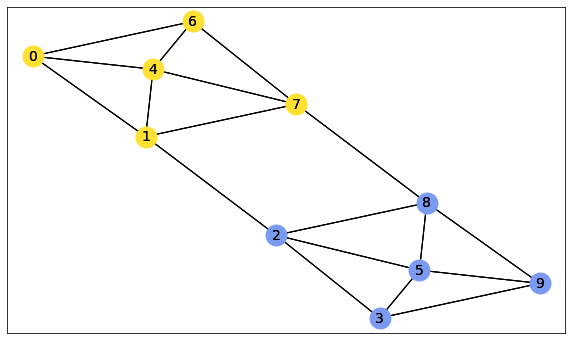

In [6]:
plt.figure(figsize=(10, 6))
node_size = 440
font_size = 14
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_1.tolist(), 
                 node_color='#FFE033', 
                 node_size=node_size, 
                 font_size=font_size)

nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 nodelist=indices_spin_minus_1.tolist(), 
                 node_color='#7B9BF2', 
                 node_size=node_size, 
                 font_size=font_size)

nx.draw_networkx_edges(graph, pos=nodes_positions)
plt.show()